Using cpu

=== FedAvg Aggregation (3 Byzantine Clients) ===
Round 01 | Train Loss: 1.8390 | Train Acc: 65.82% | Val Loss: 11.4529 | Val Acc: 10.48%
Round 02 | Train Loss: 1.2284 | Train Acc: 83.99% | Val Loss: 11.3638 | Val Acc: 12.08%
Round 03 | Train Loss: 1.2602 | Train Acc: 82.91% | Val Loss: 15.9437 | Val Acc: 15.87%
Round 04 | Train Loss: 1.5370 | Train Acc: 83.33% | Val Loss: 7.3551 | Val Acc: 23.85%
Round 05 | Train Loss: 1.3558 | Train Acc: 83.29% | Val Loss: 13.1144 | Val Acc: 23.00%
Round 06 | Train Loss: 1.4238 | Train Acc: 83.79% | Val Loss: 10.0439 | Val Acc: 33.17%
Round 07 | Train Loss: 1.4930 | Train Acc: 81.92% | Val Loss: 9.7962 | Val Acc: 33.75%
Round 08 | Train Loss: 1.6410 | Train Acc: 81.21% | Val Loss: 8.7534 | Val Acc: 35.68%
Round 09 | Train Loss: 1.6835 | Train Acc: 80.84% | Val Loss: 13.0340 | Val Acc: 31.98%
Round 10 | Train Loss: 1.8193 | Train Acc: 81.08% | Val Loss: 8.1970 | Val Acc: 40.05%

=== Krum Aggregation (f=3 Byzantine Clients) ===
Round 01 | Tra

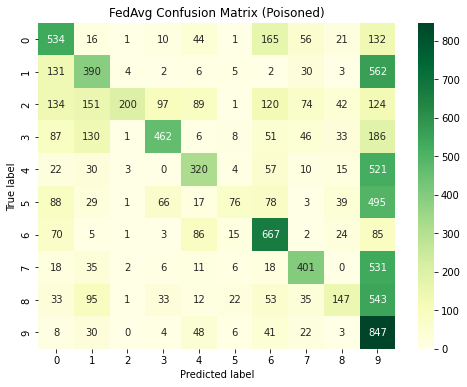



--- Final Test Results (Krum) ---
[Test] Accuracy: 93.51% | Loss: 0.2048


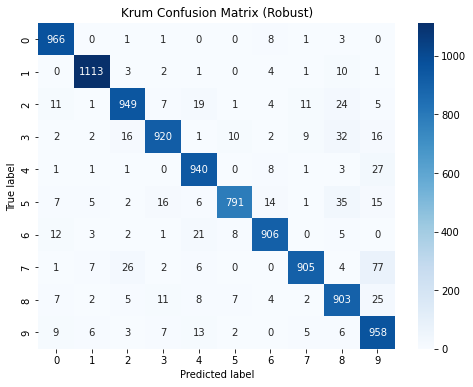



--- Validation Accuracy Comparison Plot ---


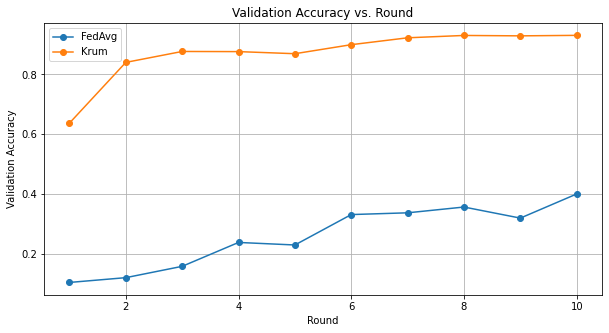

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import copy
import random
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns 


num_clients = 10
num_byzantine = 3
num_rounds = 10
local_epochs = 1
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

data_per_client = len(train_dataset) // num_clients

client_datasets = random_split(train_dataset, [data_per_client]*num_clients)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class_names = [str(i) for i in range(10)]


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


def train_local(model, dataset, epochs=1):
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    total_loss, count = 0, 0
    for _ in range(epochs):
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(data), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
            count += data.size(0)
    return model.state_dict(), total_loss / count


def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            loss_sum += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    return correct / total, loss_sum / total


def fed_avg(updates):
    avg = copy.deepcopy(updates[0][0])
    for k in avg.keys():
        avg[k] = torch.zeros_like(avg[k])
    for update, _ in updates:
        for k in avg.keys():
            avg[k] += update[k]
    for k in avg.keys():
        avg[k] /= len(updates)
    return avg


def krum(updates, f):
    n = len(updates)
    distances = torch.zeros((n, n))
    
    
    for i in range(n):
        for j in range(i+1, n):
            dist = 0
            for k in updates[i][0].keys():
                dist += torch.norm(updates[i][0][k] - updates[j][0][k])**2
            distances[i][j] = distances[j][i] = dist
            
    
    krum_scores = []
    for i in range(n):
        dists = torch.sort(distances[i])[0]
        
        score = torch.sum(dists[1:(n - f)])
        krum_scores.append(score)
        
    chosen = torch.argmin(torch.tensor(krum_scores))
    return updates[chosen][0]


def add_byzantine_noise(global_state):
    noisy_state = {}
    
    noise_factor = 0.5 
    for k, v in global_state.items():
        noisy_state[k] = v + torch.randn_like(v) * noise_factor
    return noisy_state


def aggregateFed():
    print(f"\n=== FedAvg Aggregation ({num_byzantine} Byzantine Clients) ===")
    global_model_fedavg = SimpleCNN().to(device)
    global_state = global_model_fedavg.state_dict()
    val_acc_fed_list = [] 

    for rnd in range(1, num_rounds + 1):
        local_updates = []
        total_train_loss = 0
        total_train_acc = 0

        for cid in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_state)
            
            update, loss = train_local(local_model, client_datasets[cid], local_epochs)
            total_train_loss += loss
            
            train_acc, _ = evaluate(local_model, DataLoader(client_datasets[cid], batch_size=batch_size, shuffle=False))
            total_train_acc += train_acc

            if cid < num_byzantine:
                update = add_byzantine_noise(global_state)
                
            local_updates.append((update, len(client_datasets[cid])))

        global_state = fed_avg(local_updates)
        global_model_fedavg.load_state_dict(global_state)

        val_acc_fed, val_loss_fed = evaluate(global_model_fedavg, val_loader)
        avg_train_loss_fed = total_train_loss / num_clients
        avg_train_acc_fed = total_train_acc / num_clients
        
        val_acc_fed_list.append(val_acc_fed) 

        print(f"Round {rnd:02d} | Train Loss: {avg_train_loss_fed:.4f} | Train Acc: {avg_train_acc_fed*100:.2f}% | Val Loss: {val_loss_fed:.4f} | Val Acc: {val_acc_fed*100:.2f}%")

    return global_model_fedavg, val_acc_fed_list 


def aggregateKrum():
    print(f"\n=== Krum Aggregation (f={num_byzantine} Byzantine Clients) ===")
    global_model_krum = SimpleCNN().to(device)
    global_state = global_model_krum.state_dict()
    val_acc_krum_list = [] 

    for rnd in range(1, num_rounds + 1):
        local_updates = []
        total_train_loss = 0
        total_train_acc = 0

        for cid in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_state)
            
            update, loss = train_local(local_model, client_datasets[cid], local_epochs)
            total_train_loss += loss

            train_acc, _ = evaluate(local_model, DataLoader(client_datasets[cid], batch_size=batch_size, shuffle=False))
            total_train_acc += train_acc
            
            if cid < num_byzantine:
                update = add_byzantine_noise(global_state)
                
            local_updates.append((update, len(client_datasets[cid])))

        global_state = krum(local_updates, f=num_byzantine)
        global_model_krum.load_state_dict(global_state)

        val_acc_krum, val_loss_krum = evaluate(global_model_krum, val_loader)
        avg_train_loss_krum = total_train_loss / num_clients
        avg_train_acc_krum = total_train_acc / num_clients
        
        val_acc_krum_list.append(val_acc_krum) 

        print(f"Round {rnd:02d} | Train Loss: {avg_train_loss_krum:.4f} | Train Acc: {avg_train_acc_krum*100:.2f}% | Val Loss: {val_loss_krum:.4f} | Val Acc: {val_acc_krum*100:.2f}%")

    return global_model_krum, val_acc_krum_list 


def get_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return confusion_matrix(all_labels, all_preds, labels=range(10))


def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=True,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


fed_results = aggregateFed()
global_model_fedavg, val_acc_fed = fed_results 
krum_results = aggregateKrum()
global_model_krum, val_acc_krum = krum_results 





print("\n\n--- Final Test Results (FedAvg) ---")
test_acc_fedavg, test_loss_fedavg = evaluate(global_model_fedavg, test_loader)
print(f"[Test] Accuracy: {test_acc_fedavg*100:.2f}% | Loss: {test_loss_fedavg:.4f}")
cm_fedavg = get_confusion_matrix(global_model_fedavg, test_loader, device)


plot_confusion_matrix(cm_fedavg, classes=class_names, 
                      title="FedAvg Confusion Matrix (Poisoned)", 
                      cmap=plt.cm.YlGn)


print("\n\n--- Final Test Results (Krum) ---")
test_acc_krum, test_loss_krum = evaluate(global_model_krum, test_loader)
print(f"[Test] Accuracy: {test_acc_krum*100:.2f}% | Loss: {test_loss_krum:.4f}")
cm_krum = get_confusion_matrix(global_model_krum, test_loader, device)


plot_confusion_matrix(cm_krum, classes=class_names, 
                      title="Krum Confusion Matrix (Robust)", 
                      cmap=plt.cm.Blues)







print("\n\n--- Validation Accuracy Comparison Plot ---")
plt.figure(figsize=(10, 5))
plt.title('Validation Accuracy vs. Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.plot(range(1, num_rounds + 1), val_acc_fed, label='FedAvg', marker='o') 
plt.plot(range(1, num_rounds + 1), val_acc_krum, label='Krum', marker='o') 
plt.legend()
plt.grid(True)
plt.show()